In [2]:
!pip install contextily
!pip install geopandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 74.7 MB/s eta 0:00:00


In [3]:
import requests
from io import BytesIO
import pandas as pd
from string import Template
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt


This report examines the primary factors behind flight delays and cancellations, as well as passenger, freight and mail traffic patterns in the US domestic flight sector for 2023. Through exploratory data analysis of US domestic flight data, the study identifies significant trends and provide insights for strategic decision-making. The year 2023 provides a more representative picture of air travel patterns, as it follows the major disruptions caused by the global pandemic.


Theis report primarily utilizes the TranStats dataset from [the US Bureau of Transportation Statistics](https://data.bts.gov/), supplemented by Wikipedia's "List of Airline codes" for airline name matching. Data processing and analysis were conducted using Python, with pandas for data manipulation, matplotlib and seaborn for visualizations, and plotly.graph_objects for US map representations. Geolocation data (the latitude and longtitude information) was obtained via the geopy package.

### Data retrieval: Airline- On time Dataset

In [24]:
cols = ['FlightDate', 'Tail_Number', 'Reporting_Airline', 'Origin','OriginCityName', 'OriginStateName', 'OriginState', 'Dest','DestCityName', 'DestStateName', 'DestState', 'DepTime', 'DepDelay', 'ArrTime', 'ArrDelay',
 'Cancelled', 'CancellationCode', 'AirTime', 'Distance', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']

base = 'https://www.transtats.bts.gov/PREZIP/'
template = f'On_Time_Reporting_Carrier_On_Time_Performance_1987_present_'

def load_data(base, template, year):
  data = [] # On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2023_1
  for month in range(1,13):
    url = base + template + f'{year}_{month}.zip'
    response = requests.get(url)
    with zipfile.ZipFile(BytesIO(response.content)) as z:
      with z.open(f'On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_{year}_{month}'+'.csv') as f:
          x = pd.read_csv(f)
          x = x[cols]
          data.append(x)

  df = pd.concat(data)
  return df


In [25]:
# colab est. 2m
df_ontime = load_data(base, template, 2023)

<ipython-input-24-1959d72127a8>:14: DtypeWarning:

Columns (77,84) have mixed types. Specify dtype option on import or set low_memory=False.

<ipython-input-24-1959d72127a8>:14: DtypeWarning:

Columns (48,69,76,77,84) have mixed types. Specify dtype option on import or set low_memory=False.

<ipython-input-24-1959d72127a8>:14: DtypeWarning:

Columns (48,69,76,77,84) have mixed types. Specify dtype option on import or set low_memory=False.

<ipython-input-24-1959d72127a8>:14: DtypeWarning:

Columns (77,84) have mixed types. Specify dtype option on import or set low_memory=False.

<ipython-input-24-1959d72127a8>:14: DtypeWarning:

Columns (77,84,85) have mixed types. Specify dtype option on import or set low_memory=False.

<ipython-input-24-1959d72127a8>:14: DtypeWarning:

Columns (77,84,85,92) have mixed types. Specify dtype option on import or set low_memory=False.

<ipython-input-24-1959d72127a8>:14: DtypeWarning:

Columns (48,77,84) have mixed types. Specify dtype option on import or

#### Get Airline Codes

In [26]:
!pip install wikipedia

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11679 sha256=4b874e5fe576431d0fee8806d67f10ce9545234feec4f53d59d245747579c471
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia


In [27]:
import pandas as pd
import wikipedia as wp
html = wp.page("List_of_airline_codes").html().encode("UTF-8")
try:
    airline_codes = pd.read_html(html)[1]  # Try 2nd table first as most pages contain contents table first
except IndexError:
    airline_codes = pd.read_html(html)[0]
airline_codes

,IATA,ICAO,Airline,Call sign,Country/Region,Comments
0,PR,BOI,2GO,ABAIR,Philippines,NaN
1,NaN,EVY,"34 Squadron, Royal Australian Air Force",Multiple,NaN,NaN
2,NaN,GNL,135 Airways,GENERAL,United States,NaN
3,1A,NaN,Amadeus IT Group S.A.,NaN,Global,GDS and airline hosting system (CRS/PSS)
4,1B,NaN,Sabre travel network Asia-Pacific (ex-Abacus),NaN,APAC,Regional distribution
...,...,...,...,...,...,...
6334,NaN,CYN,Zhongyuan Aviation,ZHONGYUAN,China,ICAO Code and callsign no longer allocated
6335,3J,WZP,Zip,ZIPPER,Canada,ICAO Code and callsign no longer allocated
6336,ZG,TZP,Zipair Tokyo,ZIPPY,Japan,Subsidiary of Japan Airlines
6337,Z4,OOM,Zoom Airlines,ZOOM,Canada,"defunct, ICAO Code and callsign no longer allo..."


## Questions and focus:
* What are the top delaying airlines and their reasoning in 2023?
* What are the top cancelling airlines and their reasoning in 2023?
* Delay/Cancellation by month
* US domestic passenger flight volumn

In [28]:
df_merged = pd.merge(df_ontime, airline_codes, left_on='Reporting_Airline', right_on='IATA', how='left')

In [29]:
delay_df = df_merged[df_merged['Cancelled'] != 1.0]

In [30]:
grouped_delay = df_merged.groupby('Airline')['ArrDelay']
airlines = []
delaytime = []
for airline in grouped_delay:
  airlines.append(airline[0])
  delaytime.append(list(airline[1]))
delay = pd.DataFrame(delaytime).T
delay.columns = airlines
delay_long = delay.melt(var_name='Airline', value_name='Delay')

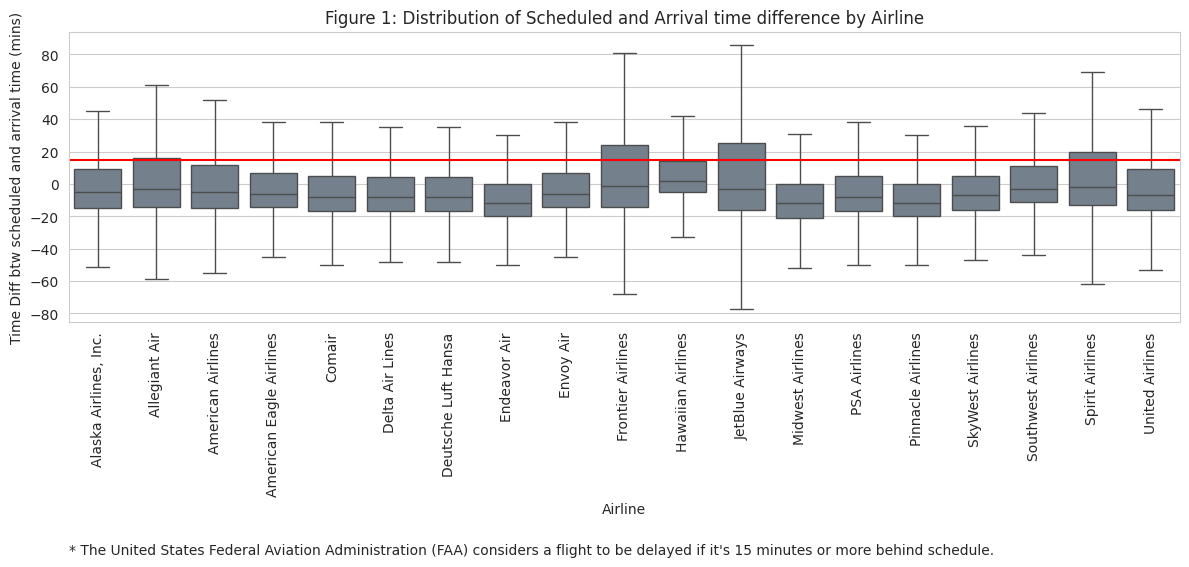

In [11]:
# box plot
plt.figure(figsize=(12, 9))
sns.set_style("whitegrid")
sns.despine(left=True)
sns.boxplot(x='Airline', y='Delay', data=delay_long, showfliers=False, color = 'slategrey')
plt.axhline(y=15, color = 'red')


plt.title('Figure 1: Distribution of Scheduled and Arrival time difference by Airline')
plt.xlabel('Airline')
plt.ylabel('Time Diff btw scheduled and arrival time (mins)')
plt.xticks(rotation=90)
plt.annotate(f"""* The United States Federal Aviation Administration (FAA) considers a flight to be delayed if it's 15 minutes or more behind schedule. """, xy = (0, -0.8), xycoords='axes fraction')
plt.tight_layout()

plt.show()

Providing flights at scheduled time are crucial to improve customer experience. Most airlines are punctual, with median arrival times close to schedule and their interquartile ranges are within ±10 minutes (Figure 1). However, low-cost carriers such as JetBlue, Frontier, and Spirit showed higher delay tendencies. The primary factors contributing to delays across all airlines were carrier delays and late aircraft (Figure 2). American Airlines demonstrated the longest average delay time.  Delta, SkyWest, and Hawaiian airlines showing a higher proportion of carrier delays, while SkyWest experienced increased weather-related delays.

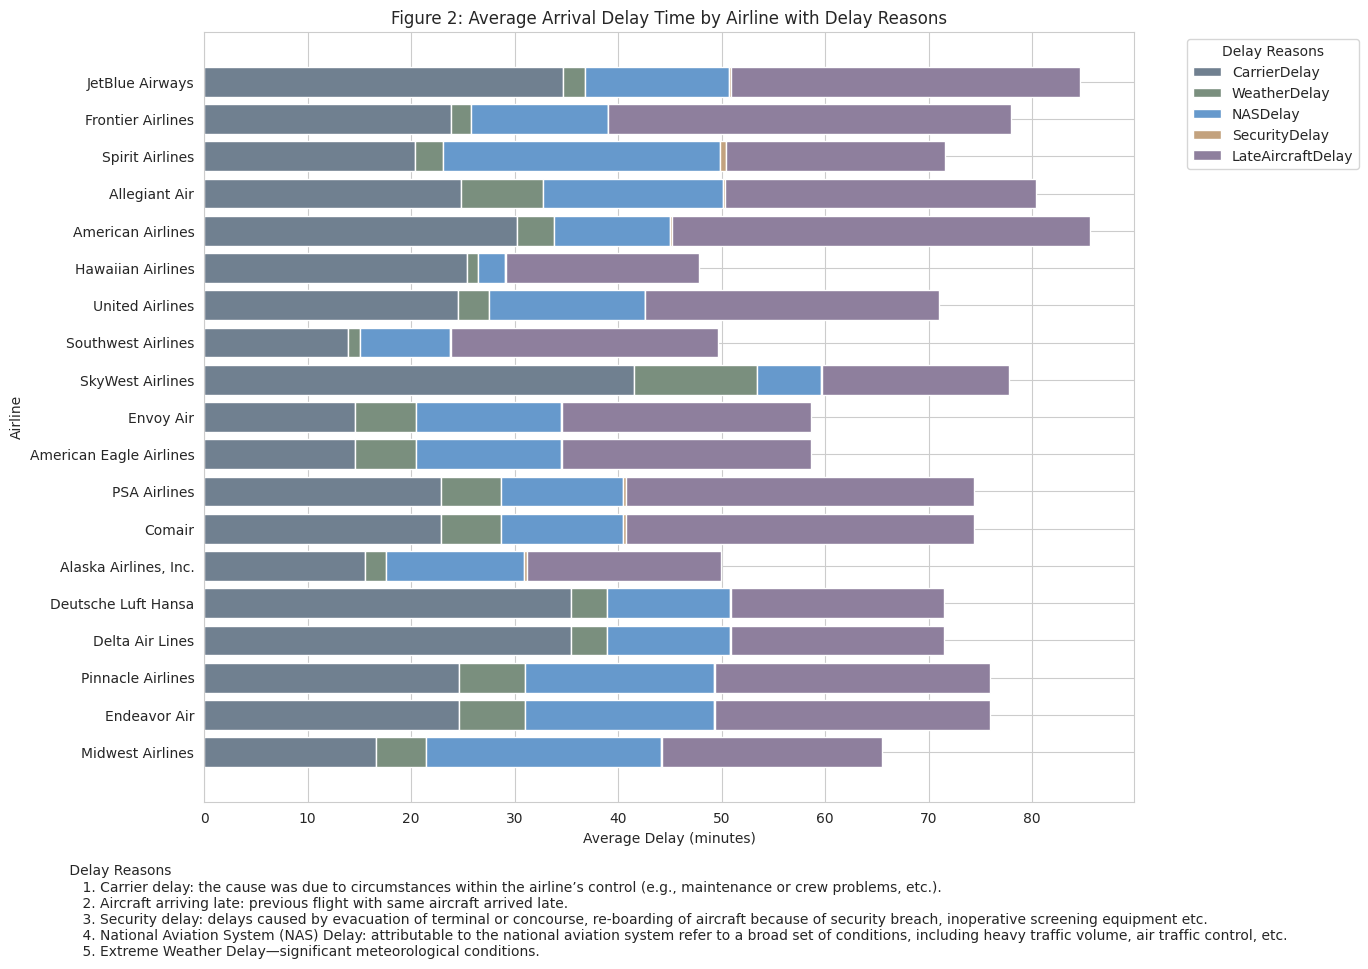

<Figure size 700x200 with 0 Axes>

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

avg_delays = delay_df.groupby('Airline')[['ArrDelay', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']].mean()
avg_delays = avg_delays.sort_values('ArrDelay', ascending=True)  # Changed to True for bottom-to-top ordering

fig, ax = plt.subplots(figsize=(12, 10))  # Adjusted figure size for better visibility
left = pd.Series(0, index=avg_delays.index)
colors = ['#708090', '#7A8F7E', '#6699CC', '#C3A27E', '#8E7F9D']
delay_reasons = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']

for reason, color in zip(delay_reasons, colors):
    ax.barh(avg_delays.index, avg_delays[reason], left=left, label=reason, color=color)
    left += avg_delays[reason]

# Customize the plot
ax.set_title('Figure 2: Average Arrival Delay Time by Airline with Delay Reasons')
ax.set_xlabel('Average Delay (minutes)')
ax.set_ylabel('Airline')
ax.annotate(f""" Delay Reasons
    1. Carrier delay: the cause was due to circumstances within the airline’s control (e.g., maintenance or crew problems, etc.).
    2. Aircraft arriving late: previous flight with same aircraft arrived late.
    3. Security delay: delays caused by evacuation of terminal or concourse, re-boarding of aircraft because of security breach, inoperative screening equipment etc.
    4. National Aviation System (NAS) Delay: attributable to the national aviation system refer to a broad set of conditions, including heavy traffic volume, air traffic control, etc.
    5. Extreme Weather Delay—significant meteorological conditions.""",
                xy = (-0.15, -0.2), xycoords='axes fraction')
ax.legend(title='Delay Reasons', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent cutting off labels
plt.figure(figsize=(7,2))
plt.tight_layout()

# Show the plot
plt.show()

In [13]:
delay_df['On-time arrival %'] = (delay_df['ArrDelay'] < 15)
delay_df.groupby('Airline')['On-time arrival %'].mean().sort_values(ascending=False)

<ipython-input-13-5e5b07c25efc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delay_df['On-time arrival %'] = (delay_df['ArrDelay'] < 15)


,On-time arrival %
Airline,
Midwest Airlines,0.867445
Endeavor Air,0.859204
Pinnacle Airlines,0.859204
SkyWest Airlines,0.834836
Delta Air Lines,0.834563
Deutsche Luft Hansa,0.834563
Comair,0.831652
PSA Airlines,0.831652
American Eagle Airlines,0.816627


In [14]:
df_merged['Cancellation Rate'] = (df_merged['Cancelled'] == 1.0)
df_merged.groupby('Airline')['Cancellation Rate'].mean().sort_values(ascending=False)

,Cancellation Rate
Airline,
Midwest Airlines,0.027645
Frontier Airlines,0.021257
Endeavor Air,0.021050
Pinnacle Airlines,0.021050
JetBlue Airways,0.020968
Spirit Airlines,0.017001
United Airlines,0.014026
Comair,0.013243
PSA Airlines,0.013243


In [15]:
cancel_df = df_merged[['Airline', 'Cancelled', 'CancellationCode']]
cancel_df['CancellationCode'] = cancel_df['CancellationCode'].map({'A': 'Carrier Caused', 'B': 'Weather', 'C':'National Aviation System', 'D':'Security'})
cancel_df['CancellationCode'].unique()

<ipython-input-15-34bb5b565f26>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancel_df['CancellationCode'] = cancel_df['CancellationCode'].map({'A': 'Carrier Caused', 'B': 'Weather', 'C':'National Aviation System', 'D':'Security'})


array([nan, 'National Aviation System', 'Weather', 'Security',
       'Carrier Caused'], dtype=object)

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

cancel_df['CancellationCode'].fillna('None', inplace=True)

# Calculate average cancelled probability for each airline
df_cancelled_avg = cancel_df.groupby('Airline')['Cancelled'].mean().reset_index()

# Calculate the proportion of each cancellation reason for each airline
reason_count = cancel_df.groupby(['Airline', 'CancellationCode']).size().unstack(fill_value=0)
reason_proportion = reason_count.div(reason_count.sum(axis=1), axis=0).reset_index()

# Ensure all potential cancellation reasons are considered
expected_columns = ['Carrier Caused', 'National Aviation System', 'Weather', 'Security']
for col in expected_columns:
    if col not in reason_proportion.columns:
        reason_proportion[col] = 0

# Merge average cancelled probability with reason proportions
merged_df = pd.merge(df_cancelled_avg, reason_proportion, on='Airline')


<ipython-input-16-76703e84d7e0>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cancel_df['CancellationCode'].fillna('None', inplace=True)
<ipython-input-16-76703e84d7e0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancel_df['CancellationCode'].fillna('None', inplace=True)


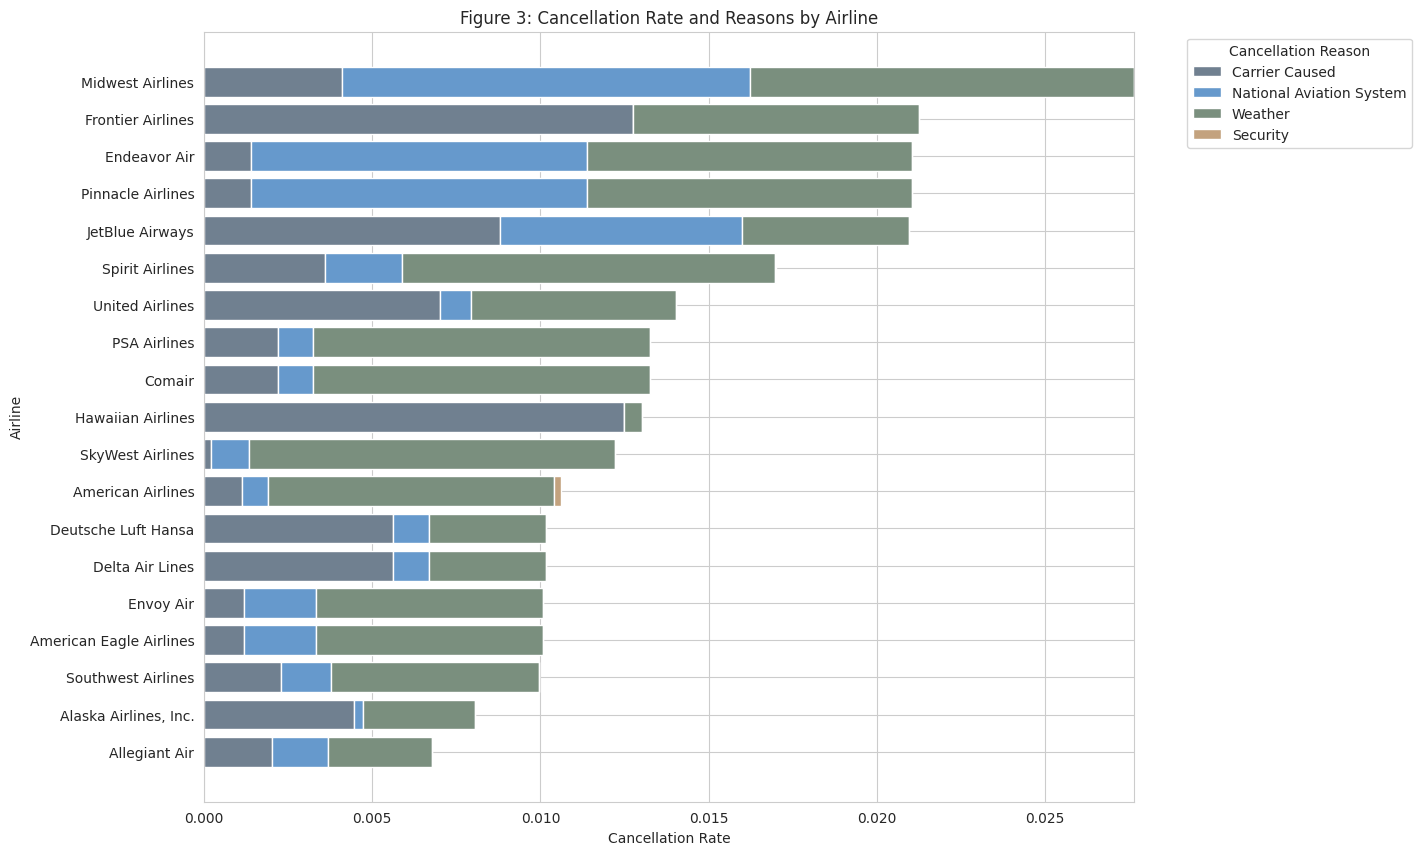

In [17]:

fig, ax = plt.subplots(figsize=(12, 10))  # Adjusted figure size for horizontal layout

# Sort airlines by cancelled probability for better visualization
merged_df = merged_df.sort_values('Cancelled', ascending=True)

# Plot each reason as its own bar, stacked on the previous one
airlines = merged_df['Airline']
left = [0] * len(airlines)

# Define colors for each reason
colors = {
    'Carrier Caused': '#708090',
    'National Aviation System': '#6699CC',
    'Weather': '#7A8F7E',
    'Security': '#C3A27E',
}

# Stacking each reason horizontally
for reason in expected_columns:
    ax.barh(airlines, merged_df[reason], left=left, label=reason, color=colors[reason])
    left = [l + r for l, r in zip(left, merged_df[reason])]

# Add legend, labels, and title
ax.legend(title='Cancellation Reason', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylabel('Airline')
ax.set_xlabel('Cancellation Rate')
ax.set_title('Figure 3: Cancellation Rate and Reasons by Airline')

plt.show()

Regarding flight cancellations (Figure 3), extreme weather conditions emerged as the main cause. How susceptible to weather conditions also reflects the routes that these airlines covered. For example, Hawaiian Airlines is less impacted by weather condition. There are almost no security-based delays or cancellation in 2023. Frontier, JetBlue, and Hawaiian Airlines exhibited higher internal carrier-caused cancellations (such as maintenance and crew problems), potentially suggesting their management issues. Interestingly, Midwest Airlines, despite good on-time performance, had the highest cancellation rate, suggesting a strategy of canceling flights rather than delaying departures when faced with unexpected circumstances. Table 1 further show that low-cost airlines are more prone to delays and cancellations.

<Axes: xlabel='Distance', ylabel='ArrDelay'>

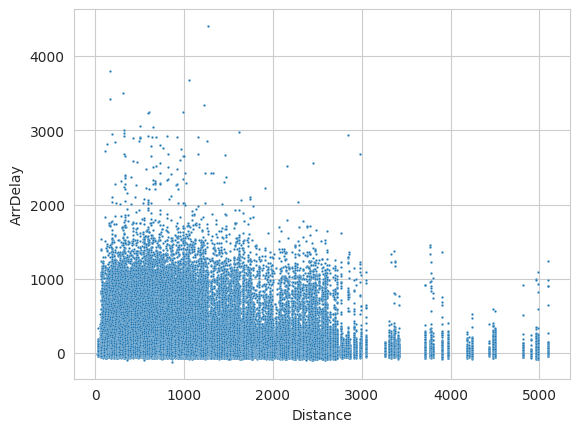

In [18]:
# Distance vs. arrival delay: there seems to be no strong correlation
# sns.scatterplot(data=df_ontime[['Distance', 'ArrDelay']].reset_index(), x='Distance', y='ArrDelay', s=3)

Next, we analyze the number of passengers on US airlines with its delay and cancellation rate across 2023 through Figure 4. Passenger numbers, delays, and cancellations all peaked around mid-2023, indicating a possible relationship between high travel volumes and service disruptions. Conversely, January and February saw the lowest passenger numbers, but the delays and cancellations remain at an average level. Moreover, there is a rebound in passenger numbers in October that was not reflected in delay and cancellation rates. The lowest delay and cancellation rate occur in November. These seasonal variations, combining the delay/cancellation reasonings provide us insights on improving airline performance and reliability.

In [14]:
t100 = pd.read_csv('/content/T_T100D_MARKET_US_CARRIER_ONLY.csv')

In [15]:
t100.head()

,PASSENGERS,FREIGHT,MAIL,DISTANCE,UNIQUE_CARRIER,UNIQUE_CARRIER_NAME,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,YEAR,QUARTER,MONTH
0,0.0,0.0,0.0,0.0,1BQ,"Eastern Airlines f/k/a Dynamic Airways, LLC",13198,MCI,"Kansas City, MO",MO,13198,MCI,"Kansas City, MO",MO,2023,4,11
1,0.0,0.0,0.0,0.0,2EQ,"J&M Alaska Air Tours, Inc. d/b/a Alaska Air Tr...",13467,MRI,"Anchorage, AK",AK,13467,MRI,"Anchorage, AK",AK,2023,3,7
2,0.0,0.0,0.0,0.0,2EQ,"J&M Alaska Air Tours, Inc. d/b/a Alaska Air Tr...",13467,MRI,"Anchorage, AK",AK,13467,MRI,"Anchorage, AK",AK,2023,3,9
3,0.0,0.0,0.0,0.0,2LQ,Tropic Ocean Airways LLC,10927,CDW,"Caldwell, NJ",NJ,10927,CDW,"Caldwell, NJ",NJ,2023,3,8
4,0.0,0.0,0.0,0.0,2LQ,Tropic Ocean Airways LLC,11697,FLL,"Fort Lauderdale, FL",FL,11697,FLL,"Fort Lauderdale, FL",FL,2023,1,2


In [16]:
# filter out the cases where the origin airport and dest airport is the same (distance == 0)
t100 = t100[t100['ORIGIN_AIRPORT_ID'] != t100['DEST_AIRPORT_ID']]
t100.head()

,PASSENGERS,FREIGHT,MAIL,DISTANCE,UNIQUE_CARRIER,UNIQUE_CARRIER_NAME,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,YEAR,QUARTER,MONTH
308,0.0,0.0,0.0,3.0,09Q,"Swift Air, LLC d/b/a Eastern Air Lines d/b/a E...",11540,ELP,"El Paso, TX",TX,10615,BIF,"El Paso, TX",TX,2023,2,6
309,0.0,0.0,0.0,3.0,KAH,Kenmore Air Harbor,14628,RSJ,"Rosario, WA",WA,15856,WSX,"Westsound, WA",WA,2023,2,4
310,0.0,0.0,0.0,3.0,KAH,Kenmore Air Harbor,15856,WSX,"Westsound, WA",WA,14628,RSJ,"Rosario, WA",WA,2023,2,4
311,0.0,0.0,0.0,3.0,KAH,Kenmore Air Harbor,15856,WSX,"Westsound, WA",WA,14628,RSJ,"Rosario, WA",WA,2023,3,7
312,0.0,0.0,0.0,3.0,KAH,Kenmore Air Harbor,15856,WSX,"Westsound, WA",WA,14628,RSJ,"Rosario, WA",WA,2023,3,8


In [31]:
# create a month column
df_merged['Month'] = df_merged['FlightDate'].apply(lambda x : x.split('-')[1])

In [33]:
month_cancel = df_merged.groupby('Month')['Cancelled'].mean().reset_index()
month_cancel

,Month,Cancelled
0,01,0.017831
1,02,0.017489
2,03,0.013521
3,04,0.017409
4,05,0.005377
5,06,0.021123
6,07,0.023862
7,08,0.015342
8,09,0.012162
9,10,0.003274


In [34]:
df_merged['Delayed'] = (df_merged['ArrDelay'] > 15)
month_delayed = df_merged.groupby('Month')['Delayed'].mean().reset_index()
month_delayed

,Month,Delayed
0,01,0.206418
1,02,0.171992
2,03,0.219067
3,04,0.207595
4,05,0.162795
5,06,0.247906
6,07,0.261184
7,08,0.199475
8,09,0.170700
9,10,0.139714


<Figure size 640x480 with 0 Axes>

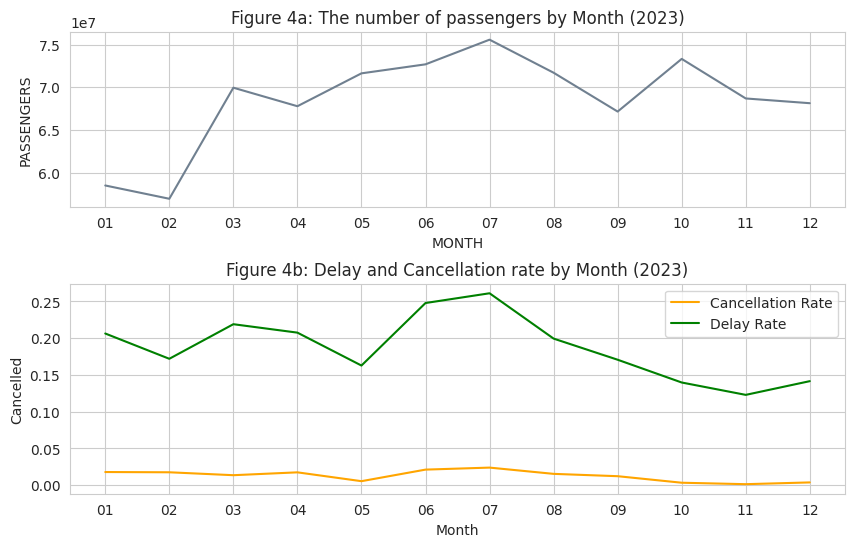

In [35]:
sns.set_style("whitegrid")
sns.despine(left=True)

figure, axes = plt.subplots(2, 1, figsize=(10, 6), height_ratios=[1, 1.2])
plt.subplots_adjust(hspace=0.4)
axes[0].set_title('Figure 4a: The number of passengers by Month (2023)')
axes[1].set_title('Figure 4b: Delay and Cancellation rate by Month (2023)')
axes[1].legend(labels=['Delay rate', 'Cancellation rate'])

t100_passengers = t100.groupby('MONTH')['PASSENGERS'].sum().reset_index()
t100_passengers['MONTH'] = month_delayed['Month']
sns.lineplot(ax=axes[0], data=t100_passengers, x='MONTH', y='PASSENGERS', color = 'slategrey')

sns.lineplot(ax=axes[1], data=month_cancel, x = 'Month', y='Cancelled', color = 'orange', label = 'Cancellation Rate')
sns.lineplot(ax=axes[1], data=month_delayed, x = 'Month', y='Delayed', color = 'green', label = 'Delay Rate')
axes[1].legend()

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import contextily as ctx
import geopandas as gpd
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
import plotly.graph_objects as go


In [17]:
t100_location = t100.groupby('ORIGIN_STATE_ABR')['PASSENGERS'].sum().reset_index()
t100_location.sort_values('PASSENGERS', ascending=False)


<Axes: title={'center': 'Figure 5c: Mail Volume by Month (2023)'}, xlabel='MONTH', ylabel='MAIL'>

<Figure size 640x480 with 0 Axes>

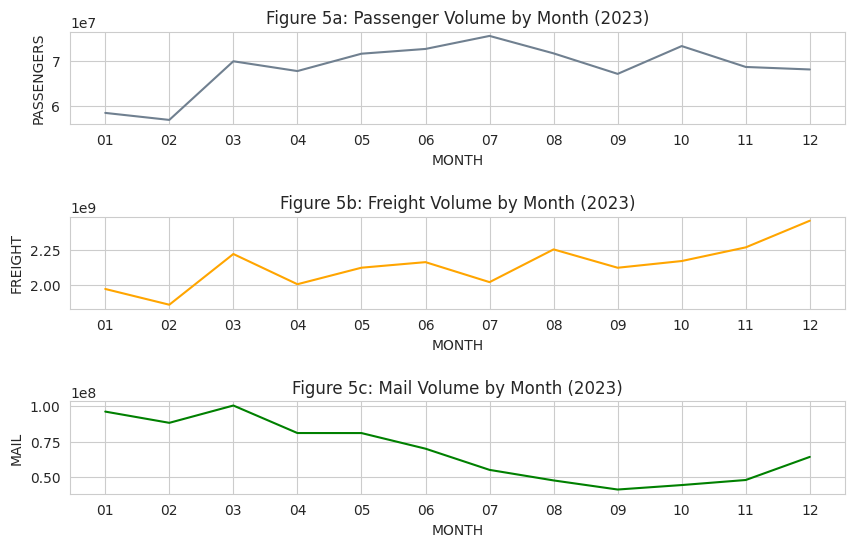

In [36]:
sns.set_style("whitegrid")
sns.despine(left=True)

# figure, axes = plt.subplots(2, 1, figsize=(10,5))

# figure.suptitle('Geeksforgeeks')
figure, axes = plt.subplots(3, 1, figsize=(10, 6))
plt.subplots_adjust(hspace=1)
axes[0].set_title('Figure 5a: Passenger Volume by Month (2023)')
axes[1].set_title('Figure 5b: Freight Volume by Month (2023)')
axes[2].set_title('Figure 5c: Mail Volume by Month (2023)')
# axes[1].legend(labels=['Delay rate', 'Cancellation rate'])



t100_passengers = t100.groupby('MONTH')['PASSENGERS'].sum().reset_index()
t100_passengers['MONTH'] = month_delayed['Month']
t100_freight = t100.groupby('MONTH')['FREIGHT'].sum().reset_index()
t100_freight['MONTH'] = month_delayed['Month']
t100_mail = t100.groupby('MONTH')['MAIL'].sum().reset_index()
t100_mail['MONTH'] = month_delayed['Month']

sns.lineplot(ax=axes[0], data=t100_passengers, x='MONTH', y='PASSENGERS', color = 'slategrey')

sns.lineplot(ax=axes[1], data=t100_freight, x = 'MONTH', y='FREIGHT', color = 'orange', label = '')
sns.lineplot(ax=axes[2], data=t100_mail,x = 'MONTH', y='MAIL', color = 'green', label = '')
# sns.lineplot(ax=axes[1], data=month_delayed,x = 'Month', y='Delayed', color = 'green', label = 'Delay Rate')
# axes[1].legend()




Beyond passenger transportation, airlines also serve in freight and mail shipping. Figure 5 illustrates the monthly volumes for these three sectors throughout 2023. Notably, the beginning of 2023 presents an inverse relationship between passenger/freight volumes and mail volume. While passenger and freight volumes are at their lowest points, mail volume peaks during this period. This could be the post-holiday surge in returns and exchanges, harsh winter weather discouraging travel and businesses conducting year-end inventory/starting new projects. As the year progresses, mail volume shows a decreasing trend until September, followed by a gradual rise. Contrastingly, freight volume demonstrates an increasing trend throughout the year, possibly due to ongoing post-pandemic economic growth, businesses restocking inventories, and preparations for the holiday shopping season. These diverse trends highlight the complex and often complementary nature of airline operations across passenger, freight, and mail services.

In [37]:
# Create the choropleth map
fig = go.Figure(data=go.Choropleth(
    locations=t100_location['ORIGIN_STATE_ABR'],  # State abbreviations
    z=t100_location['PASSENGERS'].astype(float),  # Data to be color-coded
    locationmode='USA-states',  # Set of locations match entries in `locations`
    colorscale='GnBu',
    colorbar_title="Passengers"
))

# Add state labels
fig.add_trace(go.Scattergeo(
    locations=t100_location['ORIGIN_STATE_ABR'],
    locationmode='USA-states',
    text=t100_location['ORIGIN_STATE_ABR'],
    mode='text',
    textposition="middle center",
    hoverinfo='none'
))

# Update the layout
fig.update_layout(
    title_text='Passenger Numbers by US State (Departure)',
    geo_scope='usa',  # Limit map scope to USA
)

# Show the map
fig.show()

In [ ]:
t100_location = t100.groupby('DEST_STATE_ABR')['PASSENGERS'].sum().reset_index()
import plotly.graph_objects as go
# Create the choropleth map
fig = go.Figure(data=go.Choropleth(
    locations=t100_location['DEST_STATE_ABR'],  # State abbreviations
    z=t100_location['PASSENGERS'].astype(float),  # Data to be color-coded
    locationmode='USA-states',  # Set of locations match entries in `locations`
    colorscale='GnBu',
    colorbar_title="Passengers"
))

# Add state labels
fig.add_trace(go.Scattergeo(
    locations=t100_location['DEST_STATE_ABR'],
    locationmode='USA-states',
    text=t100_location['DEST_STATE_ABR'],
    mode='text',
    textposition="middle center",
    hoverinfo='none'
))

# Update the layout
fig.update_layout(
    title_text='Passenger Numbers by US State (Arrival)',
    geo_scope='usa',  # Limit map scope to USA
)

# Show the map
fig.show()


In [ ]:
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderServiceError
import time

def get_lat_lon(city, state, country="USA"):
    geolocator = Nominatim(user_agent="my_agent")
    try:
        location = geolocator.geocode(f"{city}, {state}, {country}")
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except (GeocoderTimedOut, GeocoderServiceError):
        time.sleep(1)
        return get_lat_lon(city, state, country)


In [ ]:
t100_location = t100.groupby('ORIGIN_CITY_NAME')['PASSENGERS'].sum().reset_index()
t100_location['City'] = t100_location['ORIGIN_CITY_NAME'].apply(lambda x: x.split(',')[0])
t100_location['State'] = t100_location['ORIGIN_CITY_NAME'].apply(lambda x: x.split(',')[1].strip())
t100_location.head()

,ORIGIN_CITY_NAME,PASSENGERS,City,State
0,"Aberdeen, SD",22112.0,Aberdeen,SD
1,"Abilene, TX",79928.0,Abilene,TX
2,"Abingdon, VA",6.0,Abingdon,VA
3,"Adak Island, AK",2149.0,Adak Island,AK
4,"Afognak Lake, AK",17.0,Afognak Lake,AK


In [ ]:
t100_location = pd.read_csv('/content/t100_location.csv')
t100_location.head()

,Unnamed: 0,ORIGIN_CITY_NAME,PASSENGERS,City,State,LAT,LON,FREIGHT,MAIL
0,0,"Aberdeen, SD",22112.0,Aberdeen,SD,45.464981,-98.487813,184824.0,0.0
1,1,"Abilene, TX",79928.0,Abilene,TX,32.446450,-99.747591,451511.0,0.0
2,2,"Abingdon, VA",6.0,Abingdon,VA,36.710402,-81.975249,0.0,0.0
3,3,"Adak Island, AK",2149.0,Adak Island,AK,51.796225,-176.574423,32428.0,6659.0
4,4,"Afognak Lake, AK",17.0,Afognak Lake,AK,58.111952,-152.927990,0.0,0.0


In [ ]:
freight = t100.groupby('ORIGIN_CITY_NAME')['FREIGHT'].sum().reset_index()
mail = t100.groupby('ORIGIN_CITY_NAME')['MAIL'].sum().reset_index()

In [ ]:
t100_location['FREIGHT'] = freight['FREIGHT']
t100_location['MAIL'] = mail['MAIL']

In [ ]:
t100_location.to_csv('t100_location.csv')

In [ ]:
from tqdm import tqdm
d = {}
lat, lon = [], []
for i, row in tqdm(t100_location.iterrows(), total = len(t100_location)):
  city, state = row['City'], row['State']
  if city in d:
    lat.append(d[city][0])
    lon.append(d[city][1])
  else:
    lat_lon = get_lat_lon(city, state)
    lat.append(lat_lon[0])
    lon.append(lat_lon[1])
    d[city] = [lat_lon[0], lat_lon[1]]
t100_location['LAT'], t100_location['LON'] = lat, lon

# t100_location['LAT'], t100_location['LON'] = zip(*t100_location.apply(lambda row: get_lat_lon(row['City'], row['State']), axis=1))

100%|██████████| 1163/1163 [14:08<00:00,  1.37it/s]


In [ ]:
t100_location.head()

,ORIGIN_CITY_NAME,PASSENGERS,City,State,LAT,LON
0,"Aberdeen, SD",22112.0,Aberdeen,SD,45.464981,-98.487813
1,"Abilene, TX",79928.0,Abilene,TX,32.446450,-99.747591
2,"Abingdon, VA",6.0,Abingdon,VA,36.710402,-81.975249
3,"Adak Island, AK",2149.0,Adak Island,AK,51.796225,-176.574423
4,"Afognak Lake, AK",17.0,Afognak Lake,AK,58.111952,-152.927990


In [ ]:
t100_location.to_csv('t100_location.csv', index=False)

NameError: name 't100_location' is not defined

In [ ]:
latlon = {}
for i, row in t100_location.iterrows():
  if row['City'] not in latlon:
    latlon[row['City']] = [row['LAT'], row['LON']]



In [ ]:
df_merged['OriCity'] = df_merged['OriginCityName'].apply(lambda x: x.split(',')[0])
df_merged['DestCity'] = df_merged['DestCityName'].apply(lambda x: x.split(',')[0])
df_merged['OriLat'] = df_merged['OriCity'].apply(lambda x: latlon[x][0])
df_merged['OriLon'] = df_merged['OriCity'].apply(lambda x: latlon[x][1])
df_merged['DestLat'] = df_merged['DestCity'].apply(lambda x: latlon[x][0])
df_merged['DestLon'] = df_merged['DestCity'].apply(lambda x: latlon[x][1])

In [ ]:
import pandas as pd
import plotly.graph_objects as go

# Create the map
fig = go.Figure()

fig.update_layout(
    autosize=False,
    width=1400,
    height=800,
)

# Add the base map
fig.add_trace(go.Scattermapbox(
    lat=t100_location['LAT'],
    lon=t100_location['LON'],
    mode='markers+text',
    marker=go.scattermapbox.Marker(
        size=t100_location['PASSENGERS'] / 500000,  # Adjust this divisor to scale the bubble sizes
        color=t100_location['PASSENGERS'],
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title='Passengers')
    ),
    text=t100_location['City'],
    textposition="top center",
    hoverinfo='text',
    hovertext=t100_location['City'] + '<br>' + t100_location['PASSENGERS'].astype(str) + ' passengers'
))


fig.update_layout(
    title='Figure 6: 2023 US airport passenger volume',
    mapbox_style="open-street-map",
    mapbox=dict(
        center=dict(lat=39.8283, lon=-98.5795),  # Center of the US
        zoom=3
    ),
    showlegend=False
)

# Show the map
fig.show()

Figure 6 illustrates the passenger volume distribution across U.S. airports on a map for the year 2023. The graph reveals a clear hierarchy among the nation's busiest airports, with Atlanta leading, followed by Chicago, Dallas and Denver. The geographical distribution of high-volume airports aligns closely with population centers and major economic hubs. Almost all major cities along the east and west coasts demonstrate high levels of airport passenger traffic, reflecting the dense urban corridors in these regions. In the Midwest, Chicago serves as the primary aviation hub, while Denver dominates the central part of the country. The southern United States sees significant activity through Orlando, Atlanta, and Dallas, each serving as crucial nodes in the national air transportation network. These results are very much in line with intuition.


When examining flight delays, the data does not reveal obvious patterns across airports. However, the analysis of flight cancellations have more discernible trends. Notably, airports in the central United States and those nearby islands (such as Nantucket and Martha's Vineyard) exhibit higher cancellation rates. This could be attributed to factors such as more extreme weather conditions in the central U.S. and the operational challenges associated with serving small, isolated communities. In contrast, most major airports maintain relatively low cancellation rates, typically between 0 ~ 0.02 percent. This reflects a combination of factors. Firstly, major airports have better infrastructure and resources for them to handle various conditions more effectively; they also are assigned a higher priority to maintain service at major hubs to minimize network-wide disruptions. Furthermore, larger airports have greater flexibility in rescheduling passengers when there are cancellations, passengers may prefer going to larger airports, reinforcing the traffic airflow at major airports to grow.

In [ ]:
df_merged['Delayed'] = (df_merged['ArrDelay'] > 15)

In [ ]:
df_merged.head()

,FlightDate,Tail_Number,Reporting_Airline,Origin,OriginCityName,OriginStateName,OriginState,Dest,DestCityName,DestStateName,...,Comments,Cancellation Rate,Month,Delayed,OriCity,DestCity,OriLat,OriLon,DestLat,DestLon
0,2023-01-02,N605LR,9E,BDL,"Hartford, CT",Connecticut,CT,LGA,"New York, NY",New York,...,NaN,False,01,False,Hartford,New York,41.764582,-72.690855,40.712728,-74.006015
1,2023-01-02,N605LR,9E,BDL,"Hartford, CT",Connecticut,CT,LGA,"New York, NY",New York,...,NaN,False,01,False,Hartford,New York,41.764582,-72.690855,40.712728,-74.006015
2,2023-01-03,N605LR,9E,BDL,"Hartford, CT",Connecticut,CT,LGA,"New York, NY",New York,...,NaN,False,01,False,Hartford,New York,41.764582,-72.690855,40.712728,-74.006015
3,2023-01-03,N605LR,9E,BDL,"Hartford, CT",Connecticut,CT,LGA,"New York, NY",New York,...,NaN,False,01,False,Hartford,New York,41.764582,-72.690855,40.712728,-74.006015
4,2023-01-04,N331PQ,9E,BDL,"Hartford, CT",Connecticut,CT,LGA,"New York, NY",New York,...,NaN,False,01,False,Hartford,New York,41.764582,-72.690855,40.712728,-74.006015


In [ ]:
delayed_city = df_merged.groupby(['OriCity', 'OriLat', 'OriLon'])['Delayed'].mean().sort_values(ascending=False).reset_index()
canelled_city = df_merged.groupby(['OriCity', 'OriLat', 'OriLon'])['Cancelled'].mean().sort_values(ascending=False).reset_index()

In [ ]:
import pandas as pd
import plotly.graph_objects as go

# Create the map
fig = go.Figure()

fig.update_layout(
    autosize=False,
    width=1400,
    height=800,
)

# Add the base map
fig.add_trace(go.Scattermapbox(
    lat=canelled_city['OriLat'],
    lon=canelled_city['OriLon'],
    mode='markers+text',
    marker=go.scattermapbox.Marker(
        size=canelled_city['Cancelled'] * 600,  # Adjust this divisor to scale the bubble sizes
        color=canelled_city['Cancelled'],
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title='Cancelled')
    ),
    text=t100_location['City'],
    textposition="top center",
    hoverinfo='text',
    hovertext=canelled_city['OriCity'] + '<br>' + canelled_city['Cancelled'].astype(str)
))

fig.update_layout(
    title='Figure 7: 2023 US Airport Cancellation Rate',
    mapbox_style="open-street-map",
    mapbox=dict(
        center=dict(lat=39.8283, lon=-98.5795),  # Center of the US
        zoom=3
    ),
    showlegend=False
)

# Show the map
fig.show()

#### Conclusion

The analysis reveals significant variations in airline performance regarding delays and cancellations, as well as fluctuations in passenger traffic throughout the year. Low-cost carriers tend to experience more delays, while weather remains a primary factor in flight cancellations. Cancellation trends show higher rates in central US airports and those serving isolated communities. This emphasizes the need for improved weather forecasting and mitigation strategies. The inverse relationship between passenger/freight volumes and mail volume, especially at the beginning of the year, suggest that airlines can balance their operations across different service types throughout the year.